# Inicialización

Importación de las librerías principales





In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from google.colab import files
import json

In [ ]:
data = pd.read_csv('onlinefraud.csv', sep=',', decimal='.')

In [ ]:
print(data.shape)
data.head()

(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
data.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


Como se puede observar en la siguiente celda, hay una descompensación demasiado elevada como para llevar a cabo un correcto entrenamiento. A pesar de que hay algoritmos que llevan bien el desbalanceo de clases, una relación tan desiquilibrada no permitiría al modelo aprender lo suficiente de la clase minoritaria.

In [ ]:
data['isFraud'].value_counts()

,count
isFraud,
0,6354407
1,8213




---



# Reducción del tamaño del conjunto de datos

Teniendo información previa sobre los problemas que puede causar el añadir la variable *isFlaggedFraud* (ver memoria TFM), y tras ver que solo 16 transacciones tienen marcada este valor a 1, se decide quitarla ya que no va a aportar nada relevante al algoritmo.

In [ ]:
data['isFlaggedFraud'].value_counts()

,count
isFlaggedFraud,
0,6362604
1,16


In [ ]:
data=data[data['isFlaggedFraud'] != 1]

data=data.drop(['isFlaggedFraud'], axis=1)

In [ ]:
data.shape

(6362604, 10)

Para realizar la reducción de tamaño del dataset original de una manera inteligente que no permita la pérdida de variabilidad, se ha elegido el algoritmo MiniBatchKMeans. Este método permite conservar la información relevante de los clusters únicos que encuentra, seleccionando solamente un elemento representativo por cluster.

Se ha definido un número de clusters ligeramente superior al número de elementos de la clase minoritaria, de forma que el algoritmo puede encontrar como máximo dicho número de clusters o menos si no existen suficientes clusters únicos. Esta estrategia permite reducir el número de muestras de la clase mayoritaria sin comprometer la representatividad y diversidad de los datos, un paso crítico para evitar el sobreajuste del modelo hacia la clase mayoritaria.

Posteriormente, se restauran los valores originales de las características numéricas en los datos muestreados para asegurar coherencia en las relaciones de datos y preservar la integridad de la información en cada transacción seleccionada.

In [ ]:
# Separar las clases mayoritaria y minoritaria
majority_class = data[data['isFraud'] == 0].copy()
minority_class = data[data['isFraud'] == 1].copy()

# Realizar One-Hot Encoding de 'type' en la clase mayoritaria
majority_class_encoded = pd.get_dummies(majority_class, columns=['type'])

# Agregar una columna con el índice original
majority_class_encoded['original_index'] = majority_class_encoded.index

# Actualizar la lista de características para el clustering
features_for_clustering = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'] + \
                          [col for col in majority_class_encoded.columns if col.startswith('type_')]

# Guardar una copia de los valores originales antes de escalar
majority_class_original = majority_class_encoded.copy()

# Escalar las características numéricas para el clustering
numeric_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
scaler = StandardScaler()
majority_class_encoded[numeric_features] = scaler.fit_transform(majority_class_encoded[numeric_features])

# Realizar el clustering
n_clusters = 9000
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(majority_class_encoded[features_for_clustering])

# Añadir etiquetas de cluster
majority_class_encoded['cluster'] = kmeans.labels_

# Añadir la columna 'cluster' a majority_class_original
majority_class_original['cluster'] = kmeans.labels_

# Seleccionar una muestra aleatoria de cada cluster
sampled_majority = majority_class_encoded.groupby('cluster', group_keys=False).apply(lambda x: x.sample(1, random_state=42))

# Restaurar los valores originales en 'sampled_majority'
# Asegurarse de que los índices coinciden
sampled_majority.reset_index(drop=True, inplace=True)

# Obtener los índices originales de las muestras seleccionadas
original_indices = sampled_majority['original_index']

# Restaurar los valores originales de las características numéricas
sampled_majority[numeric_features] = majority_class_original.loc[original_indices, numeric_features].values

# Preparar la clase minoritaria
minority_class_encoded = pd.get_dummies(minority_class, columns=['type'])

# Asegurar que ambas DataFrames tienen las mismas columnas
missing_cols_majority = set(sampled_majority.columns) - set(minority_class_encoded.columns)
for col in missing_cols_majority:
    minority_class_encoded[col] = 0

missing_cols_minority = set(minority_class_encoded.columns) - set(sampled_majority.columns)
for col in missing_cols_minority:
    sampled_majority[col] = 0

# Reordenar las columnas para que coincidan
minority_class_encoded = minority_class_encoded[sampled_majority.columns]

# Combinar ambas clases
data_sampled = pd.concat([sampled_majority, minority_class_encoded], ignore_index=True)

# Verificar el tamaño y la distribución de clases
print(f'Tamaño del conjunto de datos reducido: {len(data_sampled)}')
print('Distribución de clases:')
print(data_sampled['isFraud'].value_counts())

<ipython-input-9-3178a77ada40>:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_majority = majority_class_encoded.groupby('cluster', group_keys=False).apply(lambda x: x.sample(1, random_state=42))


Tamaño del conjunto de datos reducido: 16851
Distribución de clases:
isFraud
0    8654
1    8197
Name: count, dtype: int64


Tras la reducción existosa del conjunto de datos, ahora se restaura el formato del dataset.

In [ ]:
# Eliminar la columna 'cluster'
data_sampled = data_sampled.drop(columns=['cluster'])

# Invertir el One-Hot Encoding de 'type'
type_columns = [col for col in data_sampled.columns if col.startswith('type_')]
data_sampled['type'] = data_sampled[type_columns].idxmax(axis=1).str.replace('type_', '')

# Eliminar las columnas one-hot encoded de 'type'
data_sampled = data_sampled.drop(columns=type_columns)

cols = list(data_sampled.columns)
# Reordenar colocando 'type' en la segunda posición
cols.insert(1, cols.pop(cols.index('type')))
data_sampled = data_sampled[cols]

data_sampled = data_sampled.drop(columns=['original_index'])

# Verificar el resultado
print(data_sampled.head())
print(data_sampled.columns)

   step      type       amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0   330  CASH_OUT    332720.28  C1391473624       57315.00            0.00   
1   302   CASH_IN    108062.81   C247388028    19941838.81     20049901.62   
2   304  TRANSFER  19730215.68   C319491154      120855.99            0.00   
3   328  CASH_OUT    395114.50   C845451933           0.00            0.00   
4   259   PAYMENT     10639.48  C1715932058       25629.00        14989.52   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  
0  C1382509198         2232.13       334952.41        0  
1  C1736451288      4001545.80      7745868.38        0  
2   C778559237     21036566.97     40766782.65        0  
3   C929507855      1291600.37      1686714.87        0  
4   M747000377            0.00            0.00        0  
Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='object')


In [ ]:
# Guardar el DataFrame 'data_sampled' en un archivo CSV
data_sampled.to_csv('data_sampled.csv', index=False)

In [ ]:
files.download('data_sampled.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
data_sampled['isFraud'].value_counts()

,count
isFraud,
0,8654
1,8197


# Exploración inicial

In [ ]:
sns.set_palette("pastel")
sns.set_style("ticks")

In [ ]:
data_sampled.info()
data_sampled.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16851 entries, 0 to 16850
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            16851 non-null  int64  
 1   type            16851 non-null  object 
 2   amount          16851 non-null  float64
 3   nameOrig        16851 non-null  object 
 4   oldbalanceOrg   16851 non-null  float64
 5   newbalanceOrig  16851 non-null  float64
 6   nameDest        16851 non-null  object 
 7   oldbalanceDest  16851 non-null  float64
 8   newbalanceDest  16851 non-null  float64
 9   isFraud         16851 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 1.3+ MB


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,16851.000000,1.685100e+04,1.685100e+04,1.685100e+04,1.685100e+04,1.685100e+04,16851.000000
mean,309.469764,8.681830e+05,1.617785e+06,9.279431e+05,1.315166e+06,1.809652e+06,0.486440
std,194.112115,2.000938e+06,3.841818e+06,3.353944e+06,4.968345e+06,5.666278e+06,0.499831
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,161.000000,6.184605e+04,1.707550e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,296.000000,2.071168e+05,1.752676e+05,0.000000e+00,6.665830e+04,3.153056e+05,0.000000
75%,416.000000,5.984267e+05,1.154354e+06,9.118010e+03,9.703047e+05,1.687999e+06,1.000000
max,743.000000,6.173376e+07,5.958504e+07,4.958504e+07,2.772997e+08,2.916677e+08,1.000000


# Visualización de distribuciones y relaciones

Para mejorar la interpretación visual de los datos y minimizar el efecto de valores extremos, se aplica un umbral del percentil 90 en muchas de las visualizaciones. Esto permite observar la distribución de los datos dentro de un rango más representativo, excluyendo los valores más altos que podrían distorsionar la forma general de las gráficas.

## Univariables

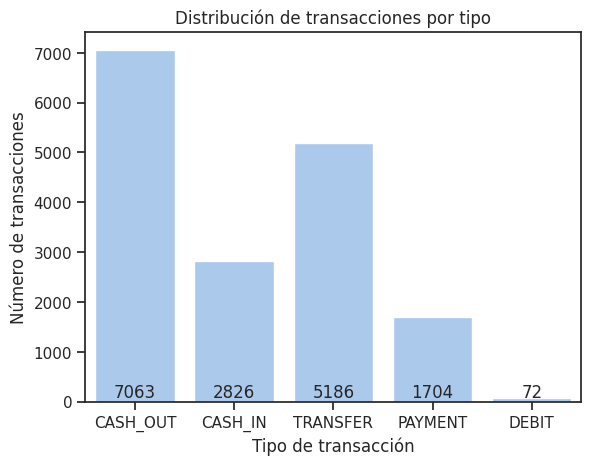

In [ ]:
ax = sns.countplot(x='type', data=data_sampled)

# Iteramos sobre cada barra y agregamos el valor de conteo como texto en la base
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., 0),
                ha='center', va='bottom')

plt.title('Distribución de transacciones por tipo')
plt.xlabel('Tipo de transacción')
plt.ylabel('Número de transacciones')
plt.show()

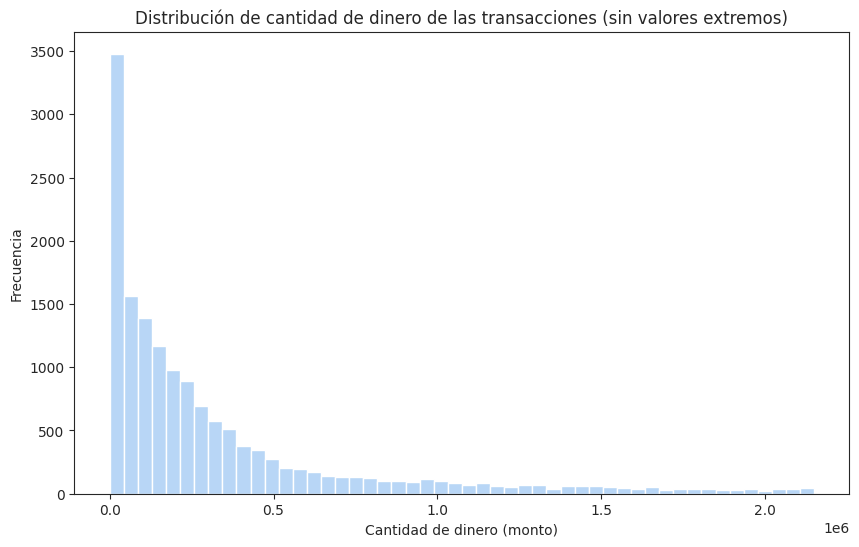

In [ ]:
threshold = data_sampled['amount'].quantile(0.9)
plt.figure(figsize=(10, 6))
sns.histplot(data_sampled[data_sampled['amount'] <= threshold]['amount'], bins=50)
plt.title('Distribución de cantidad de dinero de las transacciones (sin valores extremos)')
plt.xlabel('Cantidad de dinero (monto)')
plt.ylabel('Frecuencia')
plt.show()

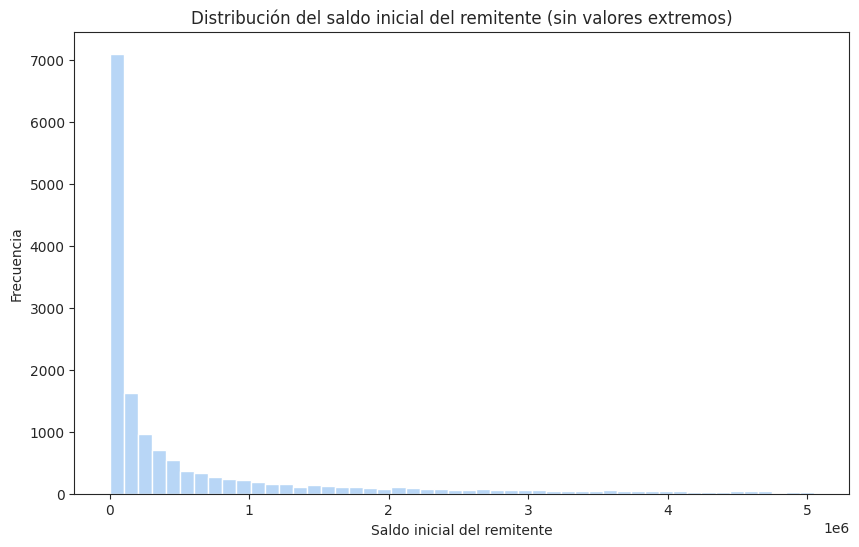

In [ ]:
threshold = data_sampled['oldbalanceOrg'].quantile(0.9)
plt.figure(figsize=(10, 6))
sns.histplot(data_sampled[data_sampled['oldbalanceOrg'] <= threshold]['oldbalanceOrg'], bins=50)
plt.title('Distribución del saldo inicial del remitente (sin valores extremos)')
plt.xlabel('Saldo inicial del remitente')
plt.ylabel('Frecuencia')
plt.show()

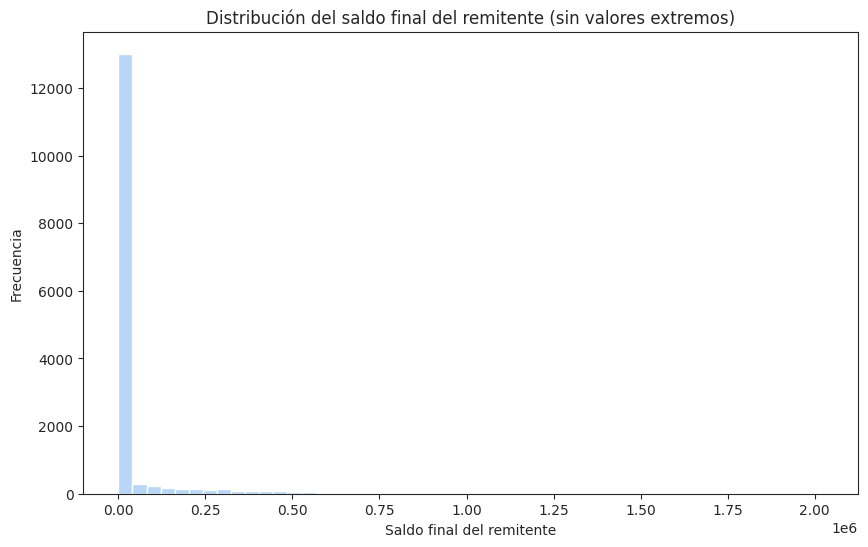

In [ ]:
threshold = data_sampled['newbalanceOrig'].quantile(0.9)
plt.figure(figsize=(10, 6))
sns.histplot(data_sampled[data_sampled['newbalanceOrig'] <= threshold]['newbalanceOrig'], bins=50)
plt.title('Distribución del saldo final del remitente (sin valores extremos)')
plt.xlabel('Saldo final del remitente')
plt.ylabel('Frecuencia')
plt.show()

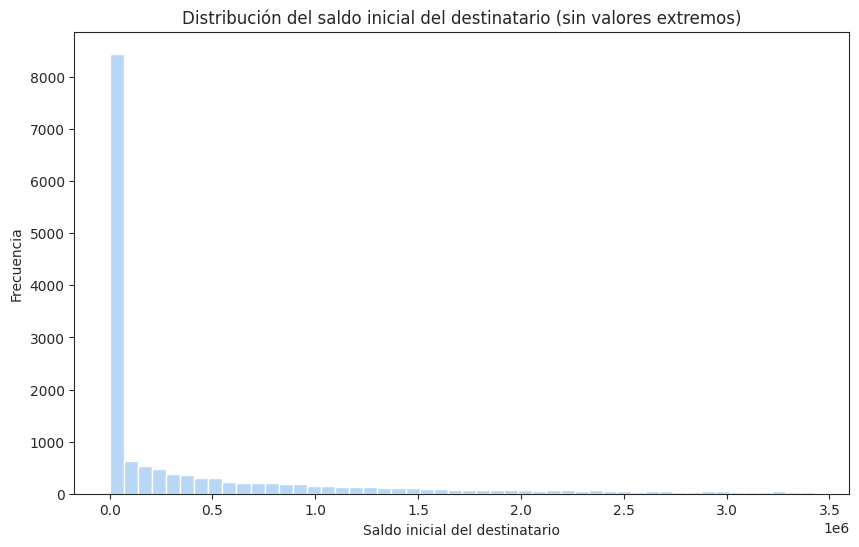

In [ ]:
threshold = data_sampled['oldbalanceDest'].quantile(0.9)
plt.figure(figsize=(10, 6))
sns.histplot(data_sampled[data_sampled['oldbalanceDest'] <= threshold]['oldbalanceDest'], bins=50)
plt.title('Distribución del saldo inicial del destinatario (sin valores extremos)')
plt.xlabel('Saldo inicial del destinatario')
plt.ylabel('Frecuencia')
plt.show()

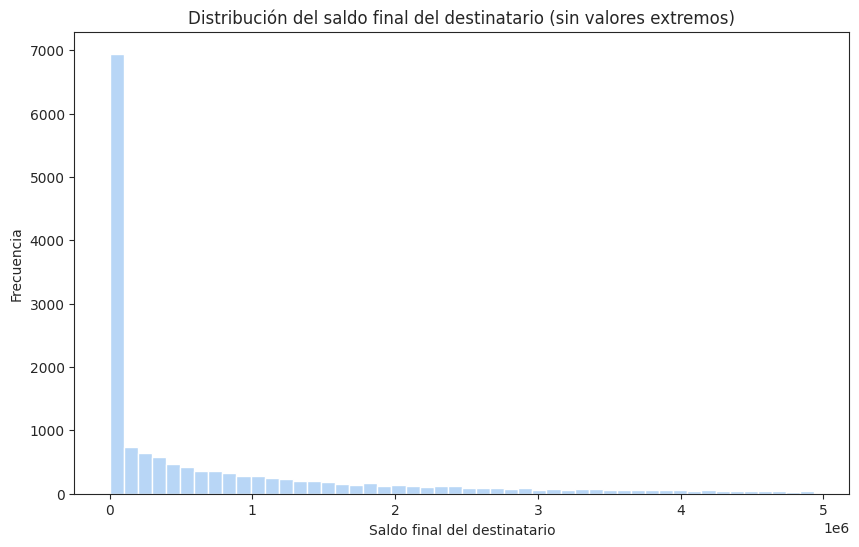

In [ ]:
threshold = data_sampled['newbalanceDest'].quantile(0.9)
plt.figure(figsize=(10, 6))
sns.histplot(data_sampled[data_sampled['newbalanceDest'] <= threshold]['newbalanceDest'], bins=50)
plt.title('Distribución del saldo final del destinatario (sin valores extremos)')
plt.xlabel('Saldo final del destinatario')
plt.ylabel('Frecuencia')
plt.show()

## Multi-variable

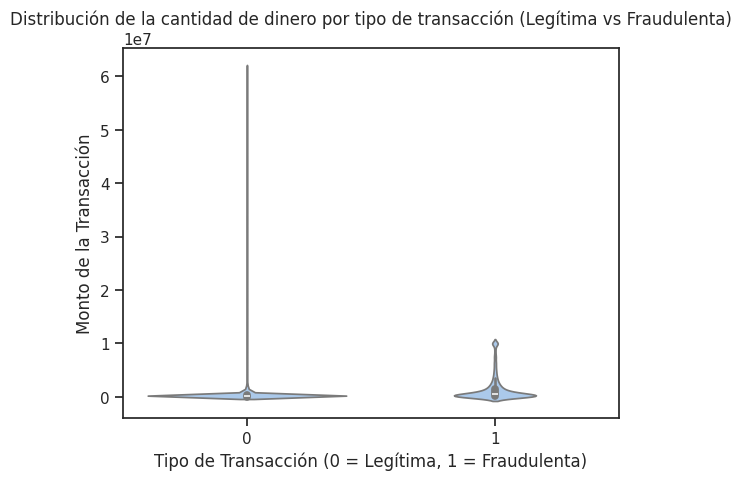

In [ ]:
sns.violinplot(x='isFraud', y='amount', data=data_sampled)

plt.title('Distribución de la cantidad de dinero por tipo de transacción (Legítima vs Fraudulenta)')
plt.xlabel('Tipo de Transacción (0 = Legítima, 1 = Fraudulenta)')
plt.ylabel('Cantidad de dinero de la Transacción')
plt.show()

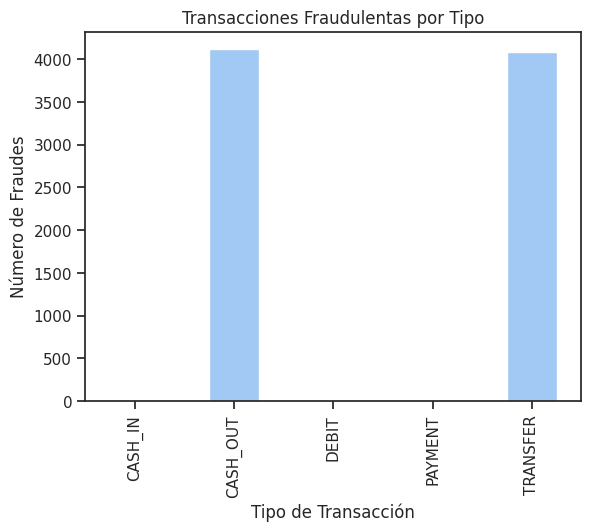

In [ ]:
fraud_by_type = data.groupby('type')['isFraud'].sum()

fraud_by_type.plot(kind='bar')
plt.title('Transacciones Fraudulentas por Tipo')
plt.xlabel('Tipo de Transacción')
plt.ylabel('Número de Fraudes')
plt.show()

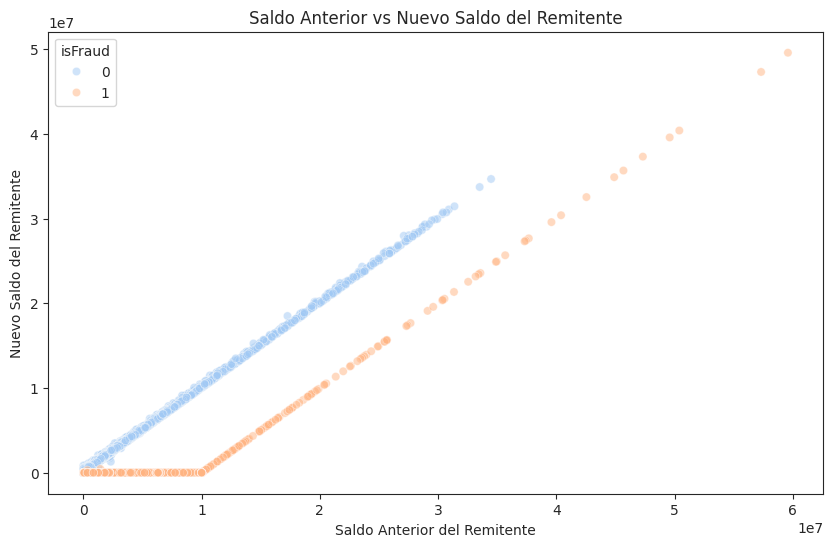

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='oldbalanceOrg', y='newbalanceOrig', hue='isFraud', data=data_sampled, alpha=0.5)
plt.title('Saldo Anterior vs Nuevo Saldo del Remitente')
plt.xlabel('Saldo Anterior del Remitente')
plt.ylabel('Nuevo Saldo del Remitente')
plt.show()

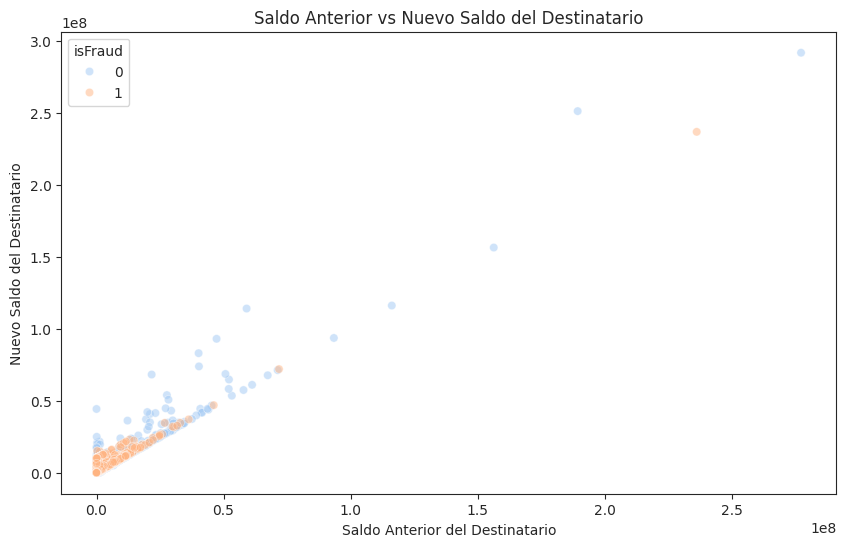

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='oldbalanceDest', y='newbalanceDest', hue='isFraud', data=data_sampled, alpha=0.5)
plt.title('Saldo Anterior vs Nuevo Saldo del Destinatario')
plt.xlabel('Saldo Anterior del Destinatario')
plt.ylabel('Nuevo Saldo del Destinatario')
plt.show()

# Análisis de valores nulos

In [ ]:
print("Total valores nulos: ", data.isnull().sum())

Total valores nulos:  step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


# Análisis avanzado de valores atípicos

ara el análisis de valores atípicos, se aplica el método del Rango Intercuartílico (IQR) para identificar observaciones que se alejan significativamente de la distribución general de los datos.

In [ ]:
def detect_outliers_iqr(df, features):
    outlier_indices = {}

    for col in features:
        # Calcular Q1 y Q3
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Calcular límites
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identificar índices de outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outlier_indices[col] = outliers

    return outlier_indices

# Lista de características a analizar
numeric_features = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Detectar outliers
outliers_dict = detect_outliers_iqr(data_sampled, numeric_features)

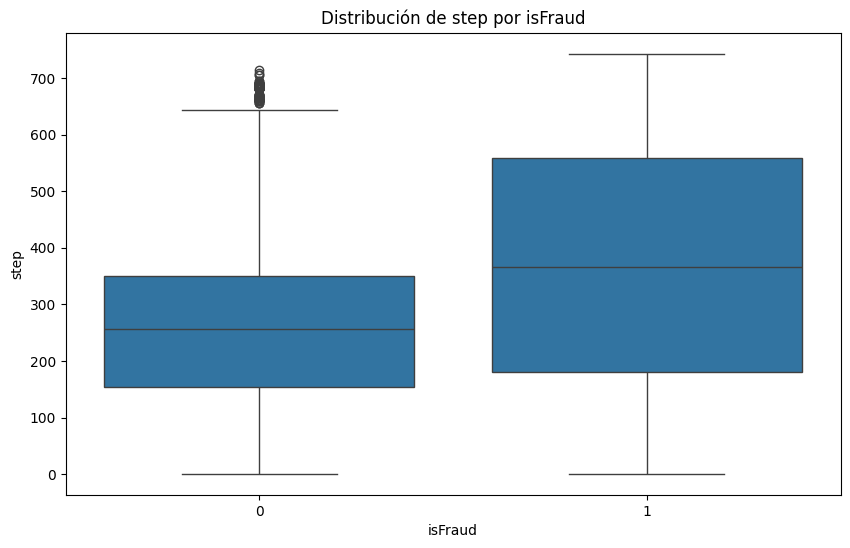

Número de outliers en step: 0
Número de fraudes en outliers de step: 0


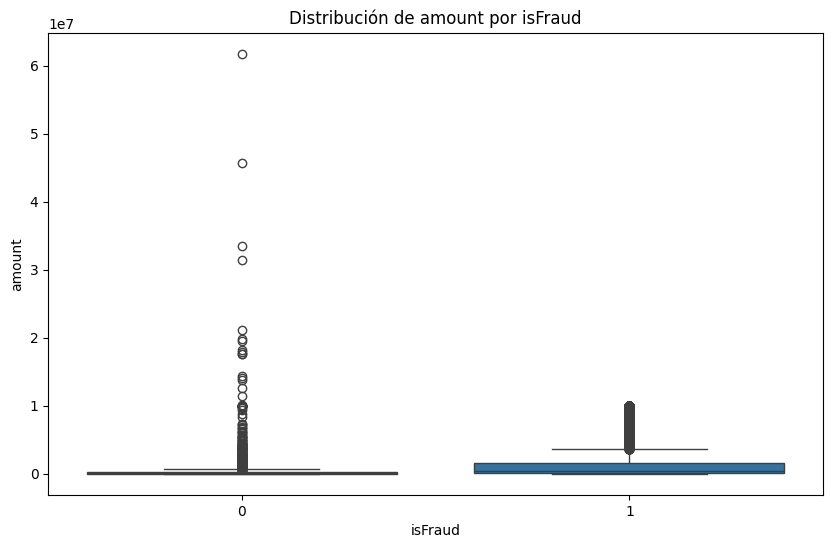

Número de outliers en amount: 2405
Número de fraudes en outliers de amount: 2167


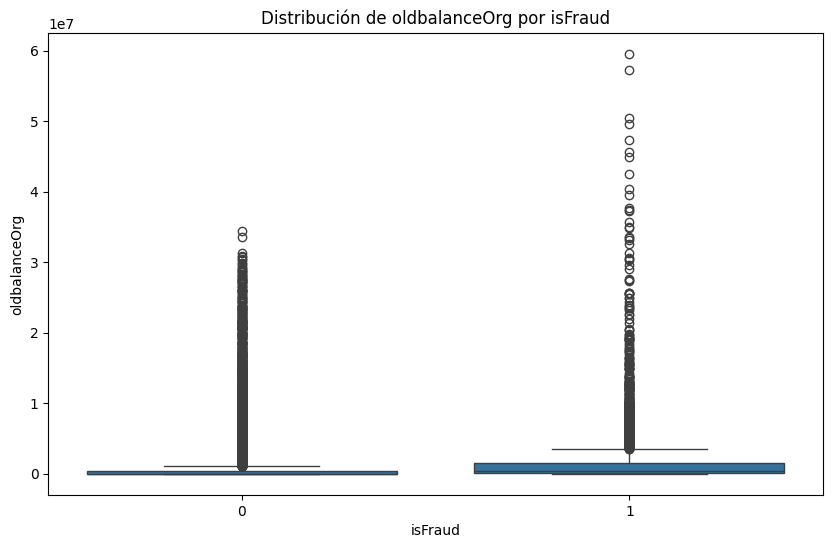

Número de outliers en oldbalanceOrg: 2570
Número de fraudes en outliers de oldbalanceOrg: 1226


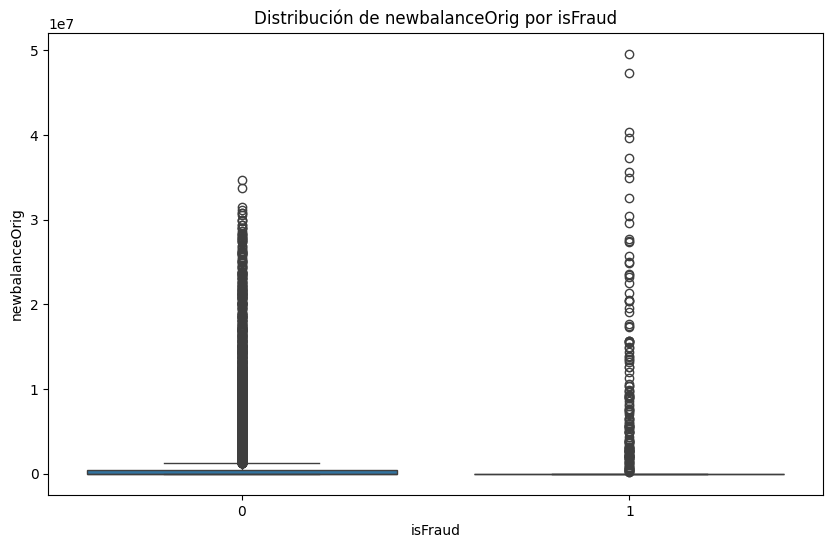

Número de outliers en newbalanceOrig: 4015
Número de fraudes en outliers de newbalanceOrig: 144


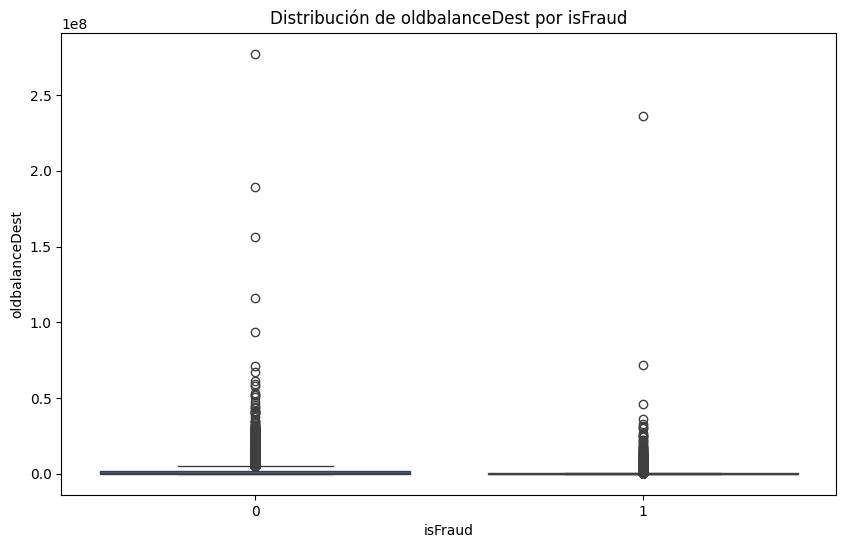

Número de outliers en oldbalanceDest: 2274
Número de fraudes en outliers de oldbalanceDest: 446


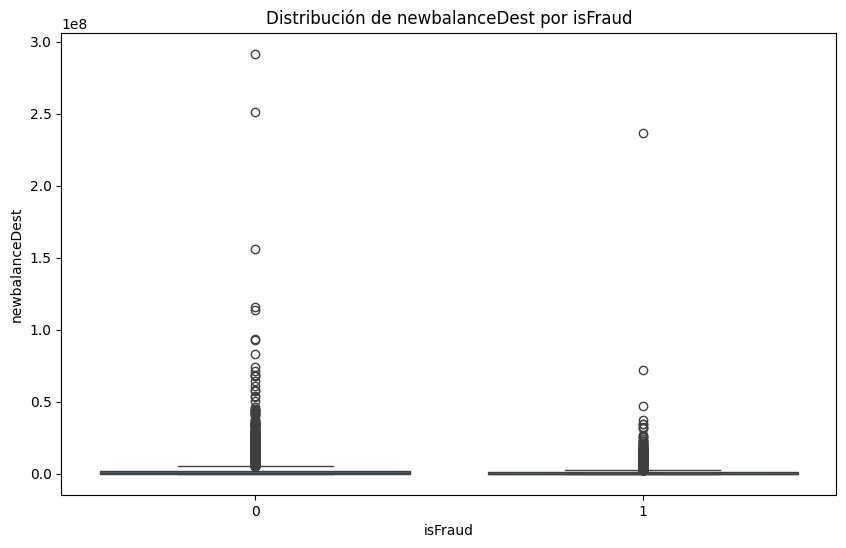

Número de outliers en newbalanceDest: 1995
Número de fraudes en outliers de newbalanceDest: 764


In [ ]:
for col in numeric_features:
    outliers = data_sampled.loc[outliers_dict[col]]
    non_outliers = data_sampled.drop(outliers_dict[col])

    plt.figure(figsize=(10,6))
    sns.boxplot(x='isFraud', y=col, data=data_sampled)
    plt.title(f'Distribución de {col} por isFraud')
    plt.show()

    print(f'Número de outliers en {col}: {len(outliers_dict[col])}')
    print(f'Número de fraudes en outliers de {col}: {outliers[outliers["isFraud"] == 1].shape[0]}')

Como se puede observar, muchas de las transacciones fraudulentas perteneces a los considerados valores atípicos

In [ ]:
# Obtener índices únicos de outliers
all_outliers_indices = set()
for indices in outliers_dict.values():
    all_outliers_indices.update(indices)

# Convertir el conjunto de índices a una lista
all_outliers_indices = list(all_outliers_indices)

# Seleccionar los outliers en el DataFrame
all_outliers = data_sampled.loc[all_outliers_indices]

# Analizar la proporción de fraudes en los outliers
fraud_in_outliers = all_outliers[all_outliers['isFraud'] == 1]
print(f'Número total de outliers: {len(all_outliers)}')
print(f'Número de fraudes en outliers: {len(fraud_in_outliers)}')
#print(f'Número de fraudes en el dataset: {}')

# Proporción de fraudes en outliers
proportion_fraud_in_outliers = len(fraud_in_outliers) / len(all_outliers)
print(f'Proporción de fraudes en outliers: {proportion_fraud_in_outliers:.4f}')

# Proporción de fraudes en el dataset completo
total_frauds = data_sampled[data_sampled['isFraud'] == 1].shape[0]
proportion_fraud_total = total_frauds / data_sampled.shape[0]
print(f'Proporción de fraudes en el dataset completo: {proportion_fraud_total:.4f}')

Número total de outliers: 7504
Número de fraudes en outliers: 2488
Proporción de fraudes en outliers: 0.3316
Proporción de fraudes en el dataset completo: 0.4864


Tras ver las proporciones que tienen los valores atípicos junto con los casos fraudulentos, se decide dejarlos presentes.

# Análisis de correlaciones

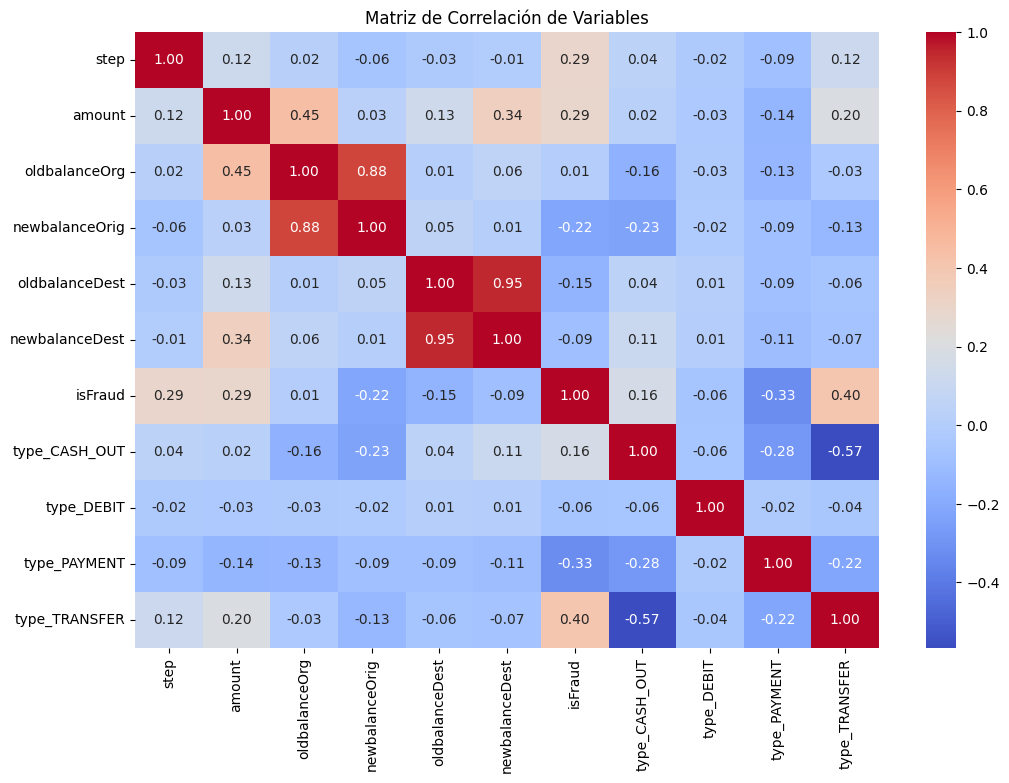

In [ ]:
data_corr = data_sampled.copy()

# Aplicar One-Hot Encoding a la variable categórica 'type'
data_corr = pd.get_dummies(data_corr, columns=['type'], drop_first=True)

# Seleccionar solo las columnas numéricas
numeric_columns = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud'] + \
                  [col for col in data_corr.columns if col.startswith('type_')]

# Generar la matriz de correlación
correlation_matrix = data_corr[numeric_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Variables')
plt.show()

# Conversión de datos

In [ ]:
def transaction_to_xml(row):
    xml = (
        f"<transaction>\n"
        f"  <step>{row['step']}</step>\n"
        f"  <type>{row['type']}</type>\n"
        f"  <amount>{row['amount']}</amount>\n"
        f"  <nameOrig>{row['nameOrig']}</nameOrig>\n"
        f"  <oldbalanceOrg>{row['oldbalanceOrg']}</oldbalanceOrg>\n"
        f"  <newbalanceOrig>{row['newbalanceOrig']}</newbalanceOrig>\n"
        f"  <nameDest>{row['nameDest']}</nameDest>\n"
        f"  <oldbalanceDest>{row['oldbalanceDest']}</oldbalanceDest>\n"
        f"  <newbalanceDest>{row['newbalanceDest']}</newbalanceDest>\n"
            # Se omite "isFraud"
        f"</transaction>"
    )
    return xml

In [ ]:
def transaction_to_html(row):
    html = (
        f"<table>\n"
        f"  <tr><th>Step</th><td>{row['step']}</td></tr>\n"
        f"  <tr><th>Type</th><td>{row['type']}</td></tr>\n"
        f"  <tr><th>Amount</th><td>{row['amount']}</td></tr>\n"
        f"  <tr><th>Name Orig</th><td>{row['nameOrig']}</td></tr>\n"
        f"  <tr><th>Old Balance Org</th><td>{row['oldbalanceOrg']}</td></tr>\n"
        f"  <tr><th>New Balance Orig</th><td>{row['newbalanceOrig']}</td></tr>\n"
        f"  <tr><th>Name Dest</th><td>{row['nameDest']}</td></tr>\n"
        f"  <tr><th>Old Balance Dest</th><td>{row['oldbalanceDest']}</td></tr>\n"
        f"  <tr><th>New Balance Dest</th><td>{row['newbalanceDest']}</td></tr>\n"
            # Se omite "isFraud"
        f"</table>"
    )
    return html

In [ ]:
def transaction_to_json(row):
    transaction = {
        "step": row['step'],
        "type": row['type'],
        "amount": row['amount'],
        "nameOrig": row['nameOrig'],
        "oldbalanceOrg": row['oldbalanceOrg'],
        "newbalanceOrig": row['newbalanceOrig'],
        "nameDest": row['nameDest'],
        "oldbalanceDest": row['oldbalanceDest'],
        "newbalanceDest": row['newbalanceDest'],
        # Se omite "isFraud"
    }
    return json.dumps(transaction, indent=2)

In [ ]:
def transaction_to_text(row):
    transaction_text = (
    f"Transaction type {row['type']} for {row['amount']} units "
    f"from account {row['nameOrig']} with an initial balance of {row['oldbalanceOrg']} "
    f"and a final balance of {row['newbalanceOrig']}, to account {row['nameDest']} "
    f"with an initial balance of {row['oldbalanceDest']} and a final balance of {row['newbalanceDest']}. "
    # Se omite "isFraud"
    )

    return transaction_text

In [ ]:
data_sampled['transaction_xml'] = data_sampled.apply(transaction_to_xml, axis=1)

data_sampled['transaction_html'] = data_sampled.apply(transaction_to_html, axis=1)

data_sampled['transaction_json'] = data_sampled.apply(transaction_to_json, axis=1)

data_sampled['transaction_natural'] = data_sampled.apply(transaction_to_text, axis=1)

In [ ]:
data_sampled.to_csv('data_t.csv', index=False)
files.download('data_t.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
data_sampled.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,transaction_xml,transaction_html,transaction_json,transaction_natural
0,330,CASH_OUT,332720.28,C1391473624,57315.00,0.00,C1382509198,2232.13,334952.41,0,<transaction>\n <step>330</step>\n <type>CAS...,<table>\n <tr><th>Step</th><td>330</td></tr>\...,"{\n ""step"": 330,\n ""type"": ""CASH_OUT"",\n ""a...",Transaction type CASH_OUT for 332720.28 units ...
1,302,CASH_IN,108062.81,C247388028,19941838.81,20049901.62,C1736451288,4001545.80,7745868.38,0,<transaction>\n <step>302</step>\n <type>CAS...,<table>\n <tr><th>Step</th><td>302</td></tr>\...,"{\n ""step"": 302,\n ""type"": ""CASH_IN"",\n ""am...",Transaction type CASH_IN for 108062.81 units f...
2,304,TRANSFER,19730215.68,C319491154,120855.99,0.00,C778559237,21036566.97,40766782.65,0,<transaction>\n <step>304</step>\n <type>TRA...,<table>\n <tr><th>Step</th><td>304</td></tr>\...,"{\n ""step"": 304,\n ""type"": ""TRANSFER"",\n ""a...",Transaction type TRANSFER for 19730215.68 unit...
3,328,CASH_OUT,395114.50,C845451933,0.00,0.00,C929507855,1291600.37,1686714.87,0,<transaction>\n <step>328</step>\n <type>CAS...,<table>\n <tr><th>Step</th><td>328</td></tr>\...,"{\n ""step"": 328,\n ""type"": ""CASH_OUT"",\n ""a...",Transaction type CASH_OUT for 395114.5 units f...
4,259,PAYMENT,10639.48,C1715932058,25629.00,14989.52,M747000377,0.00,0.00,0,<transaction>\n <step>259</step>\n <type>PAY...,<table>\n <tr><th>Step</th><td>259</td></tr>\...,"{\n ""step"": 259,\n ""type"": ""PAYMENT"",\n ""am...",Transaction type PAYMENT for 10639.48 units fr...
